Всем привет!

Перед вами задача классификации космических объектов.

Целевая переменная называется class.

Решите задачу методами случайного леса, и рассмотренными на уроке бустингами.  
Оцените результаты с помощью метрик presicion и recall.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, \
                                    RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, \
                            recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
                             AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

Прочитаем датасет.

In [2]:
df = pd.read_csv("star_classification.csv")

Он содержит довольно много колонок и многие из них являются служебными - описывают расположение объекта в библиотеке, дату снимка, инфу по камерам и прочее. Некоторые данные я не понял, но в коде на kaggle (https://www.kaggle.com/code/psycon/stars-galaxies-eda-and-classification) автор выбросил еще и несколько дполнительных колонок. Вроде бы это имеет смысл.

In [3]:
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col', 'spec_obj_ID','field_ID','fiber_ID'], axis = 1)

In [4]:
df.head()

,u,g,r,i,z,class,redshift,plate,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354
1,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445,58158
2,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576,55592
3,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149,58039
4,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121,56187


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
u,100000.0,21.980468,31.769291,-9999.000000,20.352353,22.179135,23.687440,32.781390
g,100000.0,20.531387,31.750292,-9999.000000,18.965230,21.099835,22.123767,31.602240
r,100000.0,19.645762,1.854760,9.822070,18.135828,20.125290,21.044785,29.571860
i,100000.0,19.084854,1.757895,9.469903,17.732285,19.405145,20.396495,32.141470
z,100000.0,18.668810,31.728152,-9999.000000,17.460677,19.004595,19.921120,29.383740
redshift,100000.0,0.576661,0.730707,-0.009971,0.054517,0.424173,0.704154,7.011245
plate,100000.0,5137.009660,2952.303351,266.000000,2526.000000,4987.000000,7400.250000,12547.000000
MJD,100000.0,55588.647500,1808.484233,51608.000000,54234.000000,55868.500000,56777.000000,58932.000000


Перенесем целевую переменную в конец датафрейма.

In [6]:
df.columns

Index(['u', 'g', 'r', 'i', 'z', 'class', 'redshift', 'plate', 'MJD'], dtype='object')

In [7]:
df = df[['u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'MJD', 'class']]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   u         100000 non-null  float64
 1   g         100000 non-null  float64
 2   r         100000 non-null  float64
 3   i         100000 non-null  float64
 4   z         100000 non-null  float64
 5   redshift  100000 non-null  float64
 6   plate     100000 non-null  int64  
 7   MJD       100000 non-null  int64  
 8   class     100000 non-null  object 
dtypes: float64(6), int64(2), object(1)
memory usage: 6.9+ MB


Пропусков нет, это хорошо. Разобъем колонки по категориям

In [9]:
numeric_features = df.select_dtypes(include=['int', 'float']).columns
categorical_features = df.select_dtypes(include=['object']).columns
target = df.columns[-1]

In [10]:
numeric_features

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'MJD'], dtype='object')

In [11]:
categorical_features

Index(['class'], dtype='object')

In [12]:
target

'class'

Взглянем на распредения переменных в зависимости от целевого значения. Однако датасет довольно большой. Положимся на удачу и вместо всего датасета посмотрим на его сэмпл.

In [13]:
df["class"].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

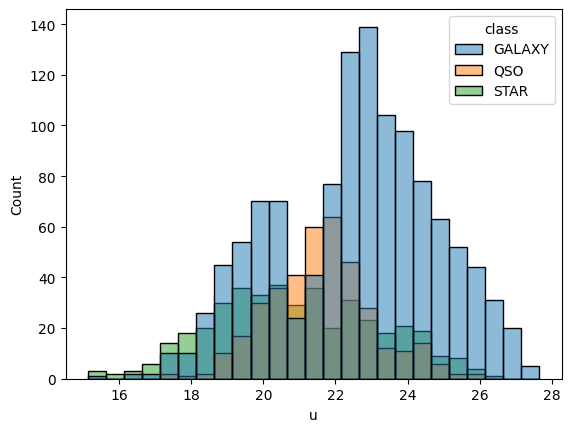

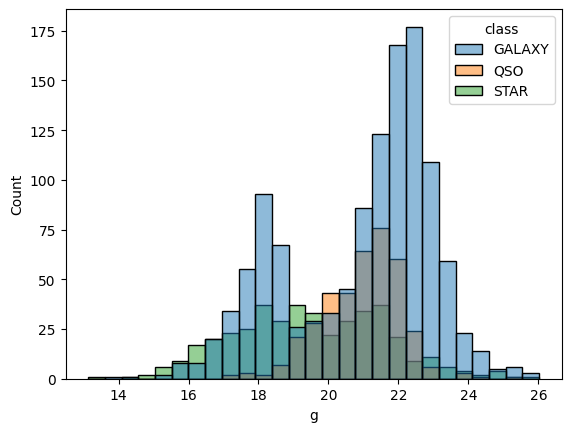

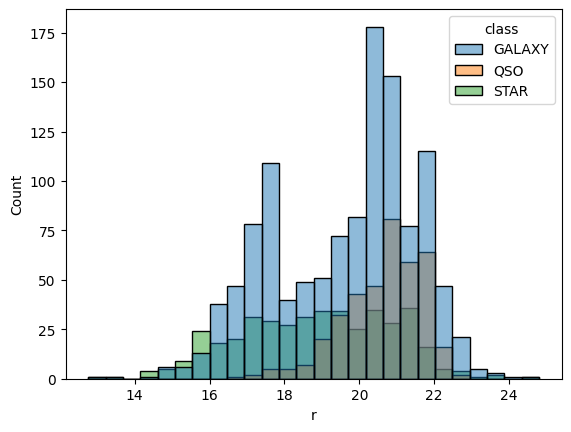

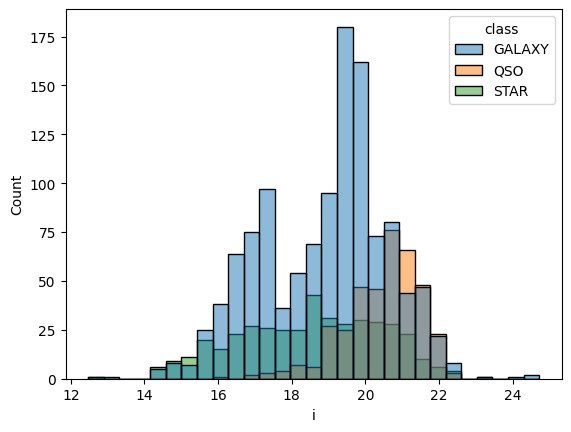

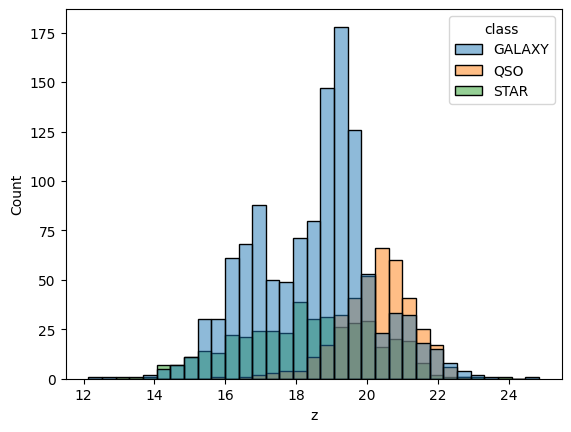

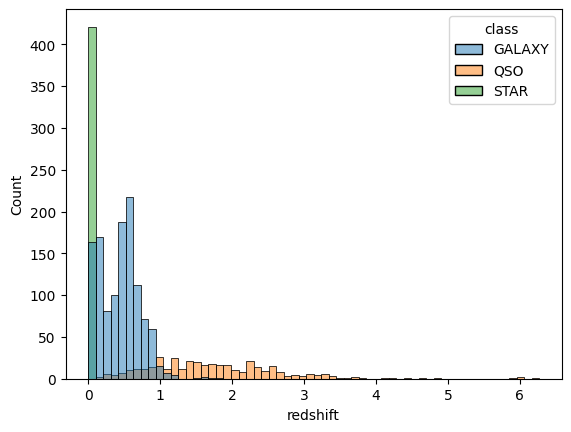

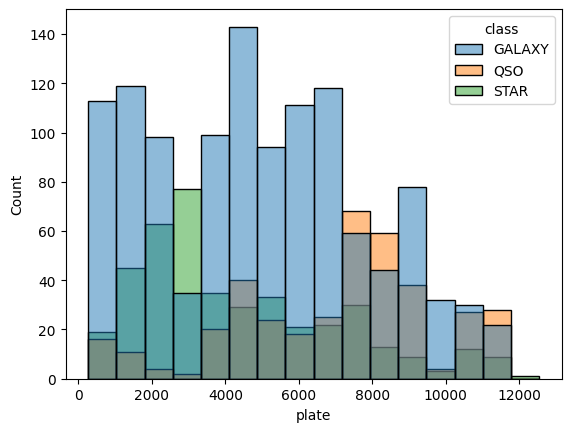

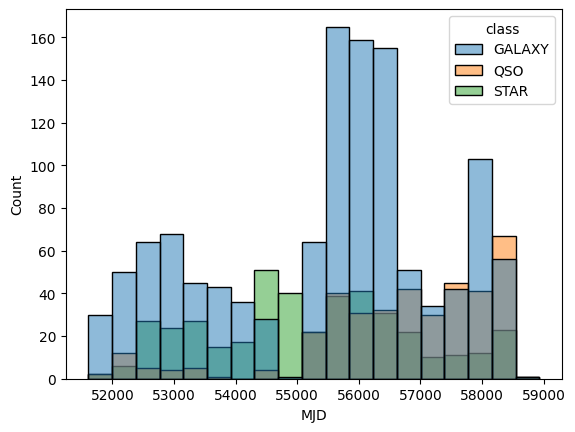

In [14]:
for feature in numeric_features:
    if feature != target:
        sns.histplot(data=df.sample(n=2000, random_state=0), x=feature, hue=target)
        plt.show()

Распределения самые разные.

Перекодируем категориальную переменную.

In [15]:
df["class"] = df["class"].map({"GALAXY": 0, "STAR": 1, "QSO": 2})

Поделимся на параметры и таргет, а потом на трейн и тест.

In [16]:
x, y = df.iloc[:, :-1], df.iloc[:, -1:]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

Обучим и применим скеллер.

In [18]:
st_scaller = StandardScaler()

In [19]:
x_train = st_scaller.fit_transform(x_train)
x_test = st_scaller.transform(x_test)

Обучим ансамблевые модели и сравним их результаты.

* Случайный лес

In [20]:
rnd_tree_clf = RandomForestClassifier(random_state=0,
                                      n_estimators=100,
                                      n_jobs=-1)

rnd_tree_clf.fit(x_train, y_train.values.ravel())
y_pred = rnd_tree_clf.predict(x_test)

In [21]:
precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro')

(0.978614116196333, 0.9718825687049657)

In [22]:
confusion_matrix(y_test, y_pred)

array([[17576,    37,   196],
       [    7,  6543,     0],
       [  395,     1,  5245]], dtype=int64)

* Градиентный бустинг

In [23]:
grad_boost_clf = GradientBoostingClassifier(random_state=0,
                                            max_depth = 4,
                                            n_estimators=100)

grad_boost_clf.fit(x_train, y_train.values.ravel())
y_pred = grad_boost_clf.predict(x_test)

In [24]:
precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro')

(0.9774551311044672, 0.9700385335683145)

In [25]:
confusion_matrix(y_test, y_pred)

array([[17570,    18,   221],
       [   11,  6538,     1],
       [  420,     1,  5220]], dtype=int64)

* Адаптивный бустинг

In [26]:
# ada_boost_clf = AdaBoostClassifier(SVC(kernel='rbf', C=1, random_state=0),
#                                    n_estimators=50,
#                                    algorithm="SAMME",
#                                    random_state=0)
# ada_boost_clf.fit(x_train, y_train.values.ravel())
# y_pred = ada_boost_clf.predict(x_test)

In [27]:
# precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro')

In [28]:
# confusion_matrix(y_test, y_pred)

In [29]:
ada_boost_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=0),
                                   n_estimators=50,
                                   algorithm="SAMME",
                                   random_state=0)
ada_boost_clf.fit(x_train, y_train.values.ravel())
y_pred = ada_boost_clf.predict(x_test)

In [30]:
precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro')

(0.9595281004358712, 0.9602094142428648)

In [31]:
confusion_matrix(y_test, y_pred)

array([[17282,    14,   513],
       [   38,  6510,     2],
       [  472,     0,  5169]], dtype=int64)

Сравним полученные данные с обычным деревом и SVC-классификатором, но уже с подбором параметров.

* SVC

In [32]:
param_distributions = {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]}

svm_search = RandomizedSearchCV(estimator=SVC(random_state=0, kernel="rbf"),
                             param_distributions=param_distributions,
                             n_iter=50,
                             random_state=0)

svm_search.fit(x_train, y_train.values.ravel())
svm_search.best_params_

c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'C': 1000}

In [33]:
svm_clf = svm_search.best_estimator_
y_pred = svm_clf.predict(x_test)

In [34]:
precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro')

(0.971543147418763, 0.968475907377793)

In [35]:
confusion_matrix(y_test, y_pred)

array([[17446,   170,   193],
       [   18,  6532,     0],
       [  393,    10,  5238]], dtype=int64)

* Дерево решений

In [36]:
param_distributions = {"criterion": ["gini", "entropy", "log_loss"],
                       "splitter": ["best", "random"],
                       "max_depth": randint(2, 20),
                       "min_samples_split": randint(2, 10),
                       "min_samples_leaf": randint(2, 10),
                       "max_leaf_nodes": randint(2, 10),
                       "max_features": ["sqrt", "log2"]}

tree_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                             param_distributions=param_distributions,
                             n_iter=500,
                             random_state=0)

tree_search.fit(x_train, y_train.values.ravel())
tree_search.best_params_

{'criterion': 'gini',
 'max_depth': 19,
 'max_features': 'log2',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'splitter': 'best'}

In [37]:
tree_clf = tree_search.best_estimator_
y_pred = tree_clf.predict(x_test)

In [38]:
precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro')

(0.9548789205634153, 0.9302118758558203)

In [39]:
confusion_matrix(y_test, y_pred)

array([[17385,   154,   270],
       [    2,  6548,     0],
       [ 1044,     1,  4596]], dtype=int64)

Выводы:
* Лучше всех себя показал Случайный лес, затем Гридиентный бустинг, затем SVC.
* Ансамблевые методы прямо из коробки (в основном) лучше, чем Дерево решений или SVC с подбором параметров.
* Подследний кстати на данных такого размера очень долго обучался... Адаптивный бустинг на основе SVC и подавно...